In [1]:
from aiida.orm import Dict, Str,List,Code,FolderData,RemoteData,Float,Int,ArrayData,load_code,Bool
from aiida.engine import run,submit,run_get_node,ExitCode,WorkChain,workfunction,calcfunction,ToContext
from aiida.plugins import DataFactory
import os
import pickle
import numpy as np

from cryspy.job import ctrl_job


StructureCollectionData = DataFactory("cryspy.structurecollection")
PandasFrameData = DataFactory('dataframe.frame')
RinData = DataFactory('cryspy.rin_data')
EAData = DataFactory('cryspy.ea_data')
StructureData = DataFactory('core.structure')

In [2]:
from aiida import load_profile
load_profile()

Profile<uuid='96abe6da047b431294d9057e5dbc634c' name='quicksetup'>

In [3]:

class initialize_workchain(WorkChain):

    @classmethod
    def define(cls,spec):
        super().define(spec)
        spec.input("cryspy_in_filename",valid_type=Str)
        #lock_cryspyをinputで入れる？

        spec.output("initial_structures",valid_type=StructureCollectionData)
        spec.output("opt_structures",valid_type=StructureCollectionData)
        spec.output("rslt_data",valid_type=PandasFrameData)
        spec.output("cryspy_in",valid_type=RinData)
        spec.output("id_queueing",valid_type=List)
        spec.output('detail_data', valid_type=(Dict,EAData))

        spec.outline(
            cls.call_crsypy_initialize
        )

    def call_crsypy_initialize(self):
        from cryspy.interactive import action
        init_struc_data, opt_struc_data, rin, rslt_data, id_queueing, detail_data = action.initialize()


        init_struc_node = StructureCollectionData(structures=init_struc_data)
        init_struc_node.store()
        self.out('initial_structures', init_struc_node)

        opt_struc_node = StructureCollectionData(structures=opt_struc_data)
        opt_struc_node.store()
        self.out('opt_structures', opt_struc_node)

        rslt_node = PandasFrameData(rslt_data)
        rslt_node.store()
        self.out('rslt_data', rslt_node)

        cryspy_in = RinData(rin)
        cryspy_in.store()
        self.out("cryspy_in", cryspy_in)

        id_queueing_node = List(list=id_queueing)
        id_queueing_node.store()
        self.out("id_queueing", id_queueing_node)

        algo = rin.algo
        
        if algo == "RS":
            RS_node = Dict(dict=detail_data)
            RS_node.store()
            self.out('detail_data', RS_node)

        elif algo == "EA":
            ea_node = EAData(detail_data)
            ea_node.store()
            self.out('detail_data', ea_node)

In [4]:
result,node = run.get_node(initialize_workchain, cryspy_in_filename="cryspy_in")

[2025-08-04 00:13:28,697][cryspy_init][INFO] 


Start CrySPY 1.4.0b10


[2025-08-04 00:13:28,698][cryspy_init][INFO] # ---------- Library version info
[2025-08-04 00:13:28,698][cryspy_init][INFO] pandas version: 2.2.2
[2025-08-04 00:13:28,699][cryspy_init][INFO] pymatgen version: 2024.6.10
[2025-08-04 00:13:28,699][cryspy_init][INFO] pyxtal version: 0.6.7
[2025-08-04 00:13:28,699][cryspy_init][INFO] # ---------- Read input file, cryspy.in
[2025-08-04 00:13:28,701][write_input][INFO] [basic]
[2025-08-04 00:13:28,701][write_input][INFO] algo = RS
[2025-08-04 00:13:28,701][write_input][INFO] calc_code = ASE
[2025-08-04 00:13:28,701][write_input][INFO] tot_struc = 3
[2025-08-04 00:13:28,702][write_input][INFO] nstage = 1
[2025-08-04 00:13:28,702][write_input][INFO] njob = 2
[2025-08-04 00:13:28,702][write_input][INFO] jobcmd = zsh
[2025-08-04 00:13:28,703][write_input][INFO] jobfile = job_cryspy
[2025-08-04 00:13:28,703][write_input][INFO] 
[2025-08-04 00:13:28,703][write_input][INFO] [str

/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:63: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf(Path(td) / self.DEFAULT_FILENAME, "w", format="table")
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:68: AiidaDeprecationWarning: `PandasFrameData.set_attribute` is deprecated, use `PandasFrameData.base.attributes.set` instead. (this will be removed in v3)
  self.set_attribute("_pandas_data_hash", self._hash_dataframe(df))
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:69: AiidaDeprecationWarning: `PandasFrameData.set_attribute` is deprecated, use `PandasFrameData.base.attributes.set` instead. (this will be removed in v3)
  self.set_attribute("index", list(df.index))
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python

In [5]:
result

{'initial_structures': <StructureCollectionData: uuid: 35de4a59-c992-433e-949c-b78c57b199de (pk: 12552)>,
 'opt_structures': <StructureCollectionData: uuid: a65d094f-180b-4a78-8420-841cdd107dd6 (pk: 12553)>,
 'rslt_data': <PandasFrameData: uuid: 08dbaf1b-45b5-4ab7-a8eb-4071c9d20211 (pk: 12554)>,
 'cryspy_in': <RinData: uuid: 587b76a8-9e9d-4b74-9781-ec167ecd97da (pk: 12555)>,
 'id_queueing': <List: uuid: f9d6b359-e084-4237-a9a4-cb2e6350ef81 (pk: 12556) value: [0, 1, 2]>,
 'detail_data': <Dict: uuid: 97fc08ad-270a-41bd-9c47-1127ec6674f9 (pk: 12557)>}

In [6]:
initial_structures_node = result['initial_structures']
opt_structures_node = result['opt_structures']
rslt_data_node = result['rslt_data']
cryspy_in_node = result['cryspy_in']
id_queueing_node = result['id_queueing']
detail_data_node = result['detail_data']

In [7]:
from aiida_mlip.data.model import ModelData
uri = "https://github.com/stfc/janus-core/raw/main/tests/models/chgnet_0.3.0_e29f68s314m37.pth.tar"
model = ModelData.from_uri(uri, architecture="chgnet", cache_dir="chgnet_models")

In [8]:
@calcfunction
def pack_results(**kwargs):
    """
    複数の計算結果ノードを受け取り、エネルギーと構造の辞書（pymatgen.as_dict()）
    をまとめた一つのDictノードを返す。
    """
    final_results = {}

    # 'id_0'のようなキーでデータをグループ化するための辞書
    grouped_data = {}
    for key, node in kwargs.items():
        # キーの名前からID部分 ("id_0"など) を取り出す
        id_ = '_'.join(key.split('_')[1:])

        # 辞書がなければ作成
        if id_ not in grouped_data:
            grouped_data[id_] = {}

        # キーのプレフィックスでresultかstructureかを判断
        if key.startswith('result_'):
            grouped_data[id_]['result'] = node
        elif key.startswith('structure_'):
            grouped_data[id_]['structure'] = node

    # グループ化されたデータを処理
    for id_, data in grouped_data.items():
        # resultノードからエネルギーを取得
        energy = data['result'].get_dict()['info']['chgnet_energy']

        # structureノードからpymatgenオブジェクトを取得し、JSON互換の辞書に変換
        struc_dict = data['structure'].get_pymatgen().as_dict()

        final_results[id_] = {'energy': energy, 'structure': struc_dict}

    # Python辞書をAiiDAのDictノードとして返す
    return Dict(dict=final_results)

# @calcfunction
# def pack_energy(**results):
#     """
#     複数の計算結果（Dictノード）を受け取り、
#     IDをキー、エネルギーを値とする一つの辞書を作成して返す。
#     """
#     energy_dict = {}

#     # results.items() をループ処理する（idは "id_0" のような文字列, val は AiiDAのDictノード）
#     for id, val in results.items():
#         # val（AiiDAのDictノード）からPython辞書を取得
#         result_dict = val.get_dict()

#         # 'info'辞書の中から'chgnet_energy'を取得
#         energy = result_dict.get('info', {}).get('chgnet_energy')

#         if energy is not None:
#             # 新しい辞書にIDとエネルギーを格納
#             energy_dict[id] = energy

#     # 最終的なPython辞書をAiiDAのDictノードに変換して返す
#     return Dict(dict=energy_dict)


class multi_structure_optimize_WorkChain(WorkChain):
    @classmethod
    def define(cls, spec):
        super().define(spec)
        spec.input("initial_structures", valid_type=StructureCollectionData, help='initial structure data for optimization')
        spec.input("opt_structures", valid_type=StructureCollectionData, help='optimized structure data')
        spec.input("rslt_data", valid_type=PandasFrameData, help='result data in Pandas DataFrame format')
        spec.input("id_queueing", valid_type=List, help='list of IDs for queuing structures for optimization')
        spec.input("cryspy_in", valid_type=RinData, help='RinData for cryspy input')
        spec.input("detail_data",valid_type=(Dict,EAData), help='EA data for optimization')
        spec.input("code", valid_type=Code, help='label of your code')
        spec.input("model", valid_type=ModelData, help='MLIP model data')
        spec.input("arch", valid_type=Str, help='architecture of the model')
        spec.input("precision", valid_type=Str, default=Str("float64"), help='precision for the calculation')
        spec.input("device", valid_type=Str, default=Str("cpu"), help='device for the calculation')
        spec.input("fmax", valid_type=Float,help='convergence criteria for geometry optimization')
        spec.input("vectors_only", valid_type=Bool,help='use vectorized calculation')
        spec.input("fully_opt", valid_type=Bool,help='full optimization flag')
        # spec.input('metadata', valid_type=Dict, default=Dict, help='metadata.options')

        # spec.output("energy_results", valid_type=Dict)
        # spec.output("all_results", valid_type=Dict, help='results of all workchains')
        # spec.output("retrieved", valid_type=FolderData)
        # spec.output("opt_structure", valid_type=StructureData)

        # spec.output_namespace("structure", valid_type=StructureData, dynamic=True)
        # spec.output_namespace("results", valid_type=Dict, dynamic=True)
        spec.output("structure_energy_data", valid_type=Dict, help='sorted energy results with structure data')
        # spec.output("results_energy", valid_type=Dict, help='sorted energy results')
        # spec.output("opt_structure", valid_type=StructureCollectionData)
        spec.output("opt_struc_data", valid_type=StructureCollectionData, help='optimized structure data')
        spec.output("rslt_data", valid_type=PandasFrameData, help='result data in Pandas DataFrame format')
        # spec.output("retrieved", valid_type=FolderData, help='retrieved data from the workchain')

        # spec.output_namespace("results", valid_type=Dict, dynamic=True)
        spec.output_namespace("structure", valid_type=StructureData, dynamic=True)
        # spec.output_namespace("retrieved", valid_type=FolderData, dynamic=True)
        # spec.output_namespace("remote_folder", valid_type=RemoteData, dynamic=True)
        # spec.output_namespace("time_dependent_computes", valid_type=ArrayData, dynamic=True)

        spec.exit_code(300, 'ERROR_SUB_PROCESS_FAILED', message='One or more subprocesses failed.')

        spec.outline(
            cls.optimize,
            cls.collect_results
        )


    def optimize(self):
        initial_structures_dict = self.inputs.initial_structures.structurecollection
        calculations = {}

        metadata = {
            'label': 'geometry_optimization',  # 計算にラベルを付ける（推奨）
            'description': 'Sub-process for geometry optimization',
            'options': {
                "resources": {"num_machines": 1, "num_mpiprocs_per_machine": 8}
            }
        }

        from aiida.plugins import CalculationFactory
        geomoptCalc = CalculationFactory("mlip.opt")

        for id in self.inputs.id_queueing:
            structure_ = initial_structures_dict[id]
            structure = StructureData(pymatgen=structure_)
            structure.store()
            self.out(f"structure.{id}", structure)

            calcjob_inputs = {
                'code': self.inputs.code,
                'model': self.inputs.model,
                'struct': structure,
                'arch': self.inputs.arch,
                'precision': self.inputs.precision,
                'device': self.inputs.device,
                'fmax': self.inputs.fmax,
                'vectors_only': self.inputs.vectors_only,
                'fully_opt': self.inputs.fully_opt,
            }

            future = self.submit(geomoptCalc,metadata=metadata,**calcjob_inputs)

            label = f"id_{id}"  # IDを文字列としてラベル付け
            calculations[label] = future

        return ToContext(**calculations)

            # self.ctx.node[id] = results_.get_node()

            # for key, node in self.ctx.results[id].items():
            #     self.out(f"{key}.{id}", node)
        # self.out("results", self.ctx.result)

    def collect_results(self):
        init_struc_data = self.inputs.initial_structures.structurecollection
        opt_struc_data = self.inputs.opt_structures.structurecollection
        structure_dict = {}
        results_dict = {}
        calcfunc_inputs = {}
        # opt_struc_data = {}


        # ---------- mkdir work/fin
        os.makedirs('work/fin', exist_ok=True)


        rslt_data_node = self.inputs.rslt_data
        # pandas.DataFrame として取り出す
        rslt_data = rslt_data_node.df


            # 成功判定のチェック
        for id, calculation in self.ctx.items():
            if not calculation.is_finished_ok:
                self.report(f'Sub-process for ID {id} failed with exit status {calculation.exit_status}')
                return self.exit_codes.ERROR_SUB_PROCESS_FAILED


        for cid, results_node in self.ctx.items():
            # cid = int(cid.split('_')[-1])  # IDを整数に変換
            # results_output = result_node.outputs
            # key = f"id_{cid}"  # ← 文字列のキーを作成
            # results_dict[cid] = results_node.outputs.results_dict
            # structure_dict[cid] = results_node.outputs.final_structure

            calcfunc_inputs[f"result_{cid}"] = results_node.outputs.results_dict
            calcfunc_inputs[f"structure_{cid}"] = results_node.outputs.final_structure

            rin_data = self.inputs.cryspy_in
            # rin オブジェクトを取り出す
            rin = rin_data.rin  # ← Python オブジェクトとして使用可能

            energy = results_node.outputs.results_dict['info']['chgnet_energy']  # 'chgnet_energy' キーからエネルギーを取得
            opt_struc = results_node.outputs.final_structure.get_pymatgen()

            print("energy:", energy)

            cid = int(cid.split('_')[-1])  # IDを整数に変換
            os.makedirs(f'work/{cid}',exist_ok=True)
            work_path = f'work/{cid}/'

            if rin.algo == "RS":
                gen_ = None

            elif rin.algo == "EA":
                gen_ = self.inputs.detail_data.ea_data[0]  # EADataから世代情報を取得

            #cryspyによる結果の保存
            opt_struc_data, rslt_data = ctrl_job.regist_opt(
                rin,
                cid,
                work_path,#どこでもいい
                init_struc_data,
                opt_struc_data,
                rslt_data,
                opt_struc,
                energy,
                magmom=np.nan,
                check_opt=None,
                ef=None,
                nat=None,
                n_selection=None,
                gen=gen_
            )

            # retrieved = results_output.retrieved
            # self.out("retrieved", retrieved)

        # results_dict_node = Dict(dict=results_dict)
        # structure_dict_node = Dict(dict=structure_dict)

        structure_energy_data_results = pack_results(**calcfunc_inputs)
        self.out("structure_energy_data", structure_energy_data_results)

        # sorted_energy = pack_energy(**results_dict)
        # self.out("results_energy", sorted_energy)

        # opt_structure = pack_structure(**structure_dict)
        # self.out("opt_structure", opt_structure)

        opt_struc_node = StructureCollectionData(structures=opt_struc_data)
        opt_struc_node.store()
        self.out('opt_struc_data', opt_struc_node)

        rslt_node = PandasFrameData(rslt_data)
        rslt_node.store()
        self.out('rslt_data', rslt_node)

In [9]:
from aiida.orm import Str, Float, Bool
from aiida.orm import load_code
code = load_code("janus@localhost")

inputs = {
        'initial_structures':initial_structures_node,
        'opt_structures':opt_structures_node,
        'id_queueing':id_queueing_node,
        'rslt_data':rslt_data_node,
        'cryspy_in':cryspy_in_node,
        'detail_data':detail_data_node,
        "code": code,
        "model": model,
        "arch": Str(model.architecture),
        "precision": Str("float64"),
        "device": Str("mps"),
        "fmax": Float(0.1), 
        "vectors_only": Bool(False), 
        "fully_opt": Bool(True), 
        # "metadata": {"options": {"resources": {"num_machines": 1,'num_mpiprocs_per_machine': 1}}},
    }

In [10]:
result,node = run.get_node(multi_structure_optimize_WorkChain, **inputs)

/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida/engine/processes/ports.py:156: UserWarning: default of input port `precision` is a `Node` instance, which can lead to unexpected side effects. It is advised to use a lambda instead, e.g.: `default=lambda: orm.Int(5)`.
  warnings.warn(UserWarning(message))
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida/engine/processes/ports.py:156: UserWarning: default of input port `device` is a `Node` instance, which can lead to unexpected side effects. It is advised to use a lambda instead, e.g.: `default=lambda: orm.Int(5)`.
  warnings.warn(UserWarning(message))


defining outputnode
energy: -46.802917480469
energy: -44.383823394775
energy: -48.044334411621


/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:63: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf(Path(td) / self.DEFAULT_FILENAME, "w", format="table")
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:68: AiidaDeprecationWarning: `PandasFrameData.set_attribute` is deprecated, use `PandasFrameData.base.attributes.set` instead. (this will be removed in v3)
  self.set_attribute("_pandas_data_hash", self._hash_dataframe(df))
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:69: AiidaDeprecationWarning: `PandasFrameData.set_attribute` is deprecated, use `PandasFrameData.base.attributes.set` instead. (this will be removed in v3)
  self.set_attribute("index", list(df.index))
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python

Success: Output written to `12564.dot.pdf`


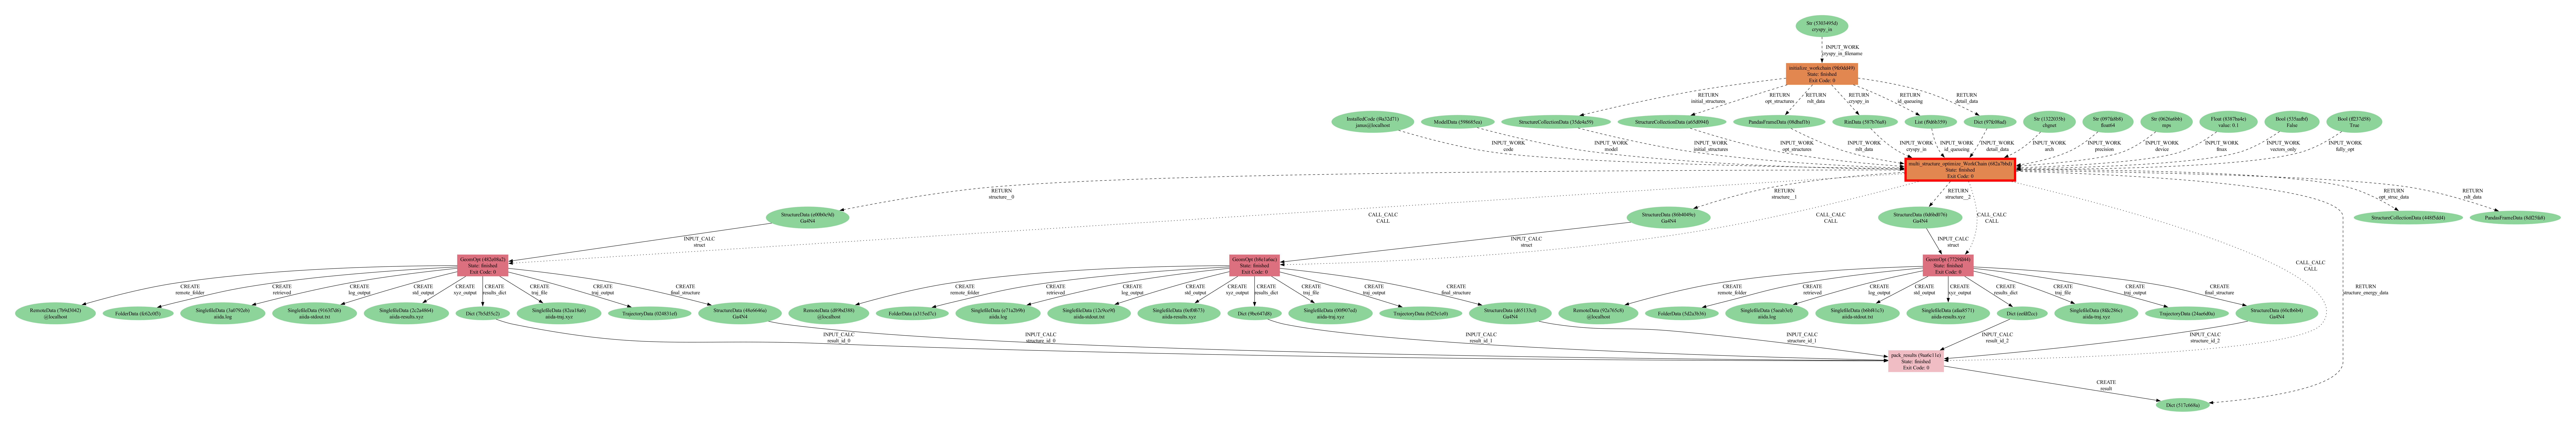

In [11]:
import subprocess
import fitz  # PyMuPDF
from PIL import Image
import io
from IPython.display import display

pk = node.pk

# Step 1: verdi コマンドで .dot.pdf を生成
subprocess.call(f"verdi node graph generate {pk}", shell=True)

# Step 2: PyMuPDF で PDF を開いて画像化
pdf_path = f"{pk}.dot.pdf"
doc = fitz.open(pdf_path)
page = doc[0]
pix = page.get_pixmap(dpi=150)

# Step 3: PIL で画像として表示
image = Image.open(io.BytesIO(pix.tobytes()))
display(image)

In [12]:
result

{'structure': {'0': <StructureData: uuid: e00b0c9d-40a4-4697-94b4-6c3763e52ff1 (pk: 12565)>,
  '1': <StructureData: uuid: 86b4049e-8bfe-4b73-ad02-127e44de3320 (pk: 12570)>,
  '2': <StructureData: uuid: 0d6bd076-d215-4fde-a749-5202c7518854 (pk: 12575)>},
 'structure_energy_data': <Dict: uuid: 517c668a-f414-4604-b1ed-da23e424d81a (pk: 12608)>,
 'opt_struc_data': <StructureCollectionData: uuid: 448f5dd4-c733-4ceb-b31c-3aea6b3b52af (pk: 12609)>,
 'rslt_data': <PandasFrameData: uuid: 8df25fa8-7d7b-4922-9a33-4ccaad701158 (pk: 12610)>}

In [13]:
result_energy = result['structure_energy_data'].get_dict()
result_energy

{'id_0': {'energy': -46.802917480469,
  'structure': {'sites': [{'abc': [4.6838990655352e-09,
      3.5861642133558e-18,
      -2.3419495863766e-08],
     'xyz': [2e-08, -2.5337314545872e-35, -1e-07],
     'label': 'Ga',
     'species': [{'occu': 1.0, 'element': 'Ga'}],
     'properties': {}},
    {'abc': [0.4999999948897, -9.6377535867467e-10, 0.50000000179913],
     'xyz': [2.13497341, 5.1069020586452e-25, 2.13497338],
     'label': 'Ga',
     'species': [{'occu': 1.0, 'element': 'Ga'}],
     'properties': {}},
    {'abc': [4.3238969132317e-08, 0.50000000071099, 0.49999999038368],
     'xyz': [1.9e-07, 2.13497344, 2.13497333],
     'label': 'Ga',
     'species': [{'occu': 1.0, 'element': 'Ga'}],
     'properties': {}},
    {'abc': [0.50000000403689, 0.49999999317023, -1.0110958247698e-08],
     'xyz': [2.13497345, 2.13497341, -4e-08],
     'label': 'Ga',
     'species': [{'occu': 1.0, 'element': 'Ga'}],
     'properties': {}},
    {'abc': [0.49999998009866, 0.49999999528775, 0.500000

In [14]:
result['opt_struc_data'].structurecollection

{0: Structure Summary
 Lattice
     abc : 4.2699468592115 4.2699468720116 4.2699467402057
  angles : 89.99999994856407 89.9999998811161 89.99999983055507
  volume : 77.85157436773693
       A : 4.2699468592115 6.3139114991546e-09 4.4298894827825e-09
       B : 6.3139104350677e-09 4.2699468720116 1.9166169278577e-09
       C : 4.4298887569949e-09 1.9166277146703e-09 4.2699467402057
     pbc : True True True
 PeriodicSite: Ga (2e-08, 3.531e-31, -1e-07) [4.684e-09, 3.586e-18, -2.342e-08]
 PeriodicSite: Ga (2.135, -3.506e-23, 2.135) [0.5, -9.638e-10, 0.5]
 PeriodicSite: Ga (1.9e-07, 2.135, 2.135) [4.324e-08, 0.5, 0.5]
 PeriodicSite: Ga (2.135, 2.135, -4e-08) [0.5, 0.5, -1.011e-08]
 PeriodicSite: N (2.135, 2.135, 2.135) [0.5, 0.5, 0.5]
 PeriodicSite: N (-1e-08, 2.135, 1e-07) [-3.081e-09, 0.5, 2.32e-08]
 PeriodicSite: N (2.135, 8e-08, 2e-08) [0.5, 1.8e-08, 4.165e-09]
 PeriodicSite: N (-1e-07, -3e-08, 2.135) [-2.394e-08, -7.25e-09, 0.5],
 1: Structure Summary
 Lattice
     abc : 5.02431941886

In [15]:
result['rslt_data'].df

,Spg_num,Spg_sym,Spg_num_opt,Spg_sym_opt,E_eV_atom,Magmom,Opt
0,225,Fm-3m,225,Fm-3m,-46.802917,NaN,None
1,131,P4_2/mmc,1,P1,-44.383823,NaN,None
2,132,P4_2/mcm,1,P1,-48.044334,NaN,None
